In [1]:
# %matplotlib inline
# ! pip install gym
# ! pip install wandb
# ! pip install pygame

In [1]:
import os
import gym
import gym_game
import pygame
import math
import random
import numpy as np
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import pkg_resources
import time
import matplotlib.pyplot as plt
import sys 

sys.path.append(os.path.abspath('../../'))
from dqn_util import *

In [3]:
# hyperparameters
config =  {
    "BATCH_SIZE":64,
    "GAMMA" : 0.95,
    "EPS_START": 1,
    "EPS_END" : 0.1,
    "EPS_DECAY" : 50000,
    "lr":0.0001, 
    # "weight_decay":1e-5,
    # ~ number of states * 4
    "REPLAY_BUFFER":10000,
    "EPISODES": 2,
    "TARGET_UPDATE": 30,
    "SAVE_FREQ": 10,
    "RESET_ENV_FREQ": 300,
    "DDQN": False,
    "MODEL_dir_file": "./model/test_refactor",
}

In [4]:
import wandb

run = wandb.init(project="refactor", entity="xdvisch", config=config)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xdvisch. Use `wandb login --relogin` to force relogin


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("GridWorld-v0", render_mode="rgb_array").unwrapped



resize = T.Compose([T.ToPILImage(),
                    T.Resize(15, interpolation=Image.CUBIC),
                    T.ToTensor()])


device

C:\Users\xande\AppData\Local\Temp\ipykernel_16584\1505004635.py:8: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(15, interpolation=Image.CUBIC),


device(type='cuda')

### steps
```text
    - 0: RIGHT
    - 1: DOWN
    - 2: LEFT
    - 3: UP
```

torch.Size([1, 3, 15, 15])


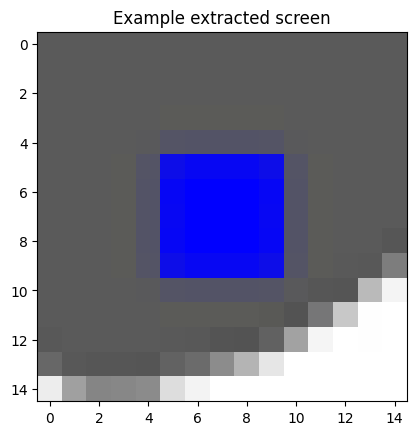

In [7]:
env.reset()

def get_screen():
    screen = env.render().transpose((2, 0, 1))  # transpose into torch order (CHW)
    _, screen_height, screen_width = screen.shape

    # full screen
    # screen = screen[:,:, 520:730]
    
    # area around agent
    # coordinaat van linkerbovenhoek rechthoek
    x_pixel_coo_agent = env._agent_location[0] * env.pix_square_size
    y_pixel_coo_agent = env._agent_location[1] * env.pix_square_size

    x_coo_right_up = x_pixel_coo_agent + 2 * env.pix_square_size
    x_coo_right_down = x_pixel_coo_agent - env.pix_square_size

    y_coo_left_down = y_pixel_coo_agent + 2 * env.pix_square_size
    y_coo_left_up = y_pixel_coo_agent - env.pix_square_size

    # left handed coordinate system
    screen = screen[:,y_coo_left_up:y_coo_left_down, x_coo_right_down:x_coo_right_up]

    

    # Convert to float, rescare, convert to torch tensor (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


plt.figure()
example_screen = get_screen()
print(example_screen.shape)
# print(f"shape of screen: {screen.example_screen}")
plt.imshow(example_screen.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()


In [9]:
from gym.wrappers.human_rendering import HumanRendering


# Define the custom x axis metric
wandb.define_metric("episode")

# Define which metrics to plot against that x-axis
wandb.define_metric("reached_target", step_metric='episode')
wandb.define_metric("win_count", step_metric='episode')
wandb.define_metric("mean_reward_over_episode", step_metric='episode')
wandb.define_metric("number_of_actions_in_episode", step_metric='episode')

def trainIters(memory, policy_net, win_count, n_iters=60):
    optimizer = optim.Adam(policy_net.parameters(), lr=config.get(
        "lr"))
    
    for iteration in range(n_iters):
        achieved_rewards = torch.tensor([], device=device)
        # wrapped = HumanRendering(env)

        # Initialize the environment and state
        env.reset()
        # wrapped.reset()

        # state based on patch of screen (3x3 around agent)
        state = get_screen()
        spel_gelukt = 0
        
        for t in count():
            env.render()
            # wrapped._render_frame()
            action = select_action(state, config, policy_net, n_actions, device)
            _, reward, done, _, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            achieved_rewards = torch.cat((achieved_rewards, reward))
            
            if not done:
                next_state = get_screen()

            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model(policy_net, optimizer, memory, config, device, target_net)

            # if agent did not reach target after RESET_ENV_FREQ actions, reset environment
            if (t + 1) % config.get("RESET_ENV_FREQ") == 0:
                done = True

            if done:
                if reward == 1000:
                    spel_gelukt = 1
                    win_count += 1

                log_dict = {
                    "episode": iteration + 1,
                    "reached_target": spel_gelukt
                }
                wandb.log(log_dict)
                wandb.log({"number_of_actions_in_episode": t})
                wandb.log({"win_count": win_count})
                wandb.log({"mean_reward_over_episode": torch.mean(achieved_rewards)})
                wandb.log({"buffer_size": memory.__len__()})
                break
            

        # Update the target network, copying all weights and biases to target DQN
        if iteration % config.get("TARGET_UPDATE") == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        # save model after frequency
        # if iteration % config.get("SAVE_FREQ") == 0:
        #     torch.save(policy_net, config.get("MODEL_dir_file") + str(iteration) + '.pkl')
        

    print('Complete')

    env.render()
    env.close()

    # wrapped.render()
    # wrapped.close()


In [10]:
memory = ReplayMemory(config.get("REPLAY_BUFFER"))

# variables for logging
win_count = 0

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. 

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n
print(n_actions)

# policy_net = torch.load('./model/gridpath_andere_afmeting_kleinere_rb.pkl')
policy_net = DQN(screen_height, screen_width, n_actions, device, 4, 1).to(device)
target_net = DQN(screen_height, screen_width, n_actions, device, 4, 1).to(device)
wandb.watch(target_net)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# 20 iteraties
trainIters(memory, policy_net, win_count, n_iters=config.get('EPISODES'))


4


d:\master\masterproef\master_thesis\repo\masterproef\dqn_util.py:124: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:28.)
  next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()


Complete


In [11]:
torch.save(policy_net, config.get("MODEL_dir_file") + 'end.pkl')